# Predicting a sine wave

Spencer Bertsch <br>
Dartmouth College, Winter 2019

Scripot to predict a sine wave and get practice using LSTM layers in a recurrent neural network. This notebook shows how to construct a three layer recurrent neural network using PyTorch in which the first two layers use LSTM units and the last layer uses a nn.linear output with a single node which applies a linear transformation to the output of the previous layer to produce a single prediction at some time (t). The results of training and testing can be seen towards the bottom of the notebook. Using 21 LSTM units in the hidden layer, it takes about six epochs for the network to learn the sine function well enough to achieve an extremely low error or loss. (The loss function in this case is simply mean squared error)

### Sources: 

The main source for this notebook was [Soumith's Githib - Time Sequence Prediction](https://github.com/pytorch/examples/tree/master/time_sequence_prediction) in which he goes through the problem of using a recurrent neural network to predict a sine wave. 

Other sources include: 

[PyTorch Containers](https://pytorch.org/docs/stable/nn.html)

[Python Tips](http://book.pythontips.com/en/latest/enumerate.html)

[Understanding Class Inheritance in Python](https://www.digitalocean.com/community/tutorials/understanding-class-inheritance-in-python-3#the-super()-function)

[PyTorch AutoGrad](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_autograd.html)

[Source Code for TORCH.NN.MODELS.LINEAR](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html)



# Generating Sine Wave Data
------

In [85]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cycler
import time 

Our goal here will be to generate 100 sine waves with equal wavelength, but each with a different phase shift. In order to achieve this goal, we will generate a vector of 100 random numbers using a random uniform distrobution, then create a 100x1000 matrix of 100 sine waves each starting from a different place between our upper and lower bounds of -4T and 4T. 

Below we define parameters for our 100 sine waves:

In [86]:
np.random.seed(2)

T = 20
L = 1000
N = 100

#Create an empty np matrix (of zeros) with shape 100x1000
x = np.zeros((N, L), 'int64')
print("Shape of matrix x:", x.shape)
print(" ")
print("Top left 5x5 matrix of matrix (x):")
print(x[:5, :5])

Shape of matrix x: (100, 1000)
 
Top left 5x5 matrix of matrix (x):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [87]:
linear_vector = np.array(range(L))
x[:] = linear_vector + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)

We first create a numpy vector with length L, then we can populate it with random numbers generated from a unifrom distrobution between bounds of -4T and 4T. <br>

These will be the starting points of our 100 phase shifted sine waves. 

In [88]:
data = np.sin(x / 1.0 / T).astype('float64')

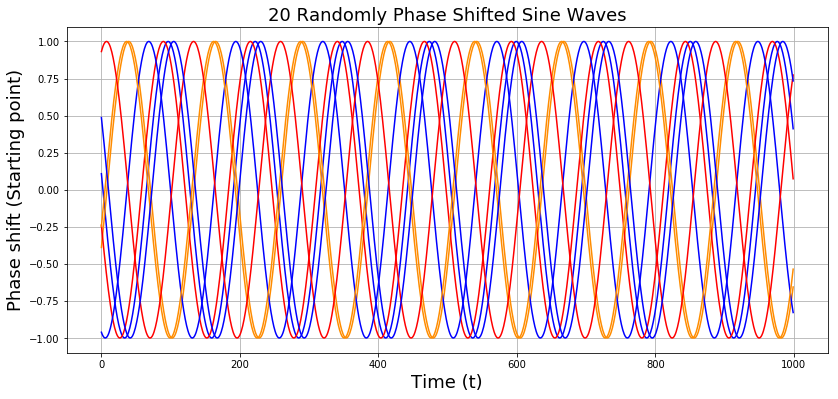

In [89]:
fig = plt.figure(figsize=(30, 6))
ax1 = fig.add_subplot(121)
plt.gca().set_prop_cycle('color', ['blue', 'darkorange', 'red'])

plt.plot(data[0, :])
plt.plot(data[1, :])
plt.plot(data[2, :])
plt.plot(data[3, :])
plt.plot(data[4, :])
plt.plot(data[5, :])
plt.plot(data[6, :])
plt.xlabel('Time (t)', fontsize = 18)
plt.ylabel('Phase shift (Starting point)', fontsize = 18)
plt.title('20 Randomly Phase Shifted Sine Waves', fontsize = 18)
plt.grid()

# Define Network Parameters
------

Now that we have several randomly phase shifted sine waves stored in 'data' we can begin to build out the network we will use for prediction

In [98]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Define the Sequence Class

I'm still learning all of the benifits that are derrived from using the super() function here. It seems like it's a very common practice when creating a sequence class in pytorch. According to [Digital Ocean](https://www.digitalocean.com/community/tutorials/understanding-class-inheritance-in-python-3#the-super()-function), "With the super() function, you can gain access to inherited methods that have been overwritten in a class object. When we use the super() function, we are calling a parent method into a child method to make use of it. For example, we may want to override one aspect of the parent method with certain functionality, but then call the rest of the original parent method to finish the method." 

In [91]:
"""
We can now create a Sequence class which we will later use to instantiate a seq object. 
This will be the network which we use to train on our time series data and once it's
trained to approximate our function, we will use the 'future' method to predict values 
into the future. 

This is all made possible by the use of the LSTM nodes in the network 
"""
units = 21 #<-- Define the number of hidden LSTM units in the middle layer of the network 

class Sequence(nn.Module):
    def __init__(self):
        
        """
        ---------- SELF ----------
        The 'self' function will construct a three layer neural network using LSTM nodes and a linear output layer
        This output will represent the resulting position of the next point in the sine wave
        """
        
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, units)#<-- LSTM Cell 1 to 51 units
        self.lstm2 = nn.LSTMCell(units, units)#<-- LSTM Cell 51 units
        self.linear = nn.Linear(units, 1)#<-- Linear cell for final prediction
        
        """
        ---------- FORWARD ----------
        The forward function takes three inputs including 'input' and 'future'
        
        'input' represents the training data: a 100x1000 matrix of sine waves
        each new row of inputs represents a different phase shifted sine which the
        network will subsequently learn. If future=0, then no predictions are made
        and the network will simply generate outputs 
        
        'output' represents the network's approximation of the data, or the 
        output of the function after training. If future=/0 then the Sequence object 
        will simply run the below "Future" loop and continue to append each row 
        vector which resides in the input tensor with the next time series prediction
        according to the function which the network has approximated. In this case, 
        the true function f*(x)=sin(x)+b, where b is some random number between -4T and 4T
       
        """
        
    def forward(self, input, future = 0):
        outputs = [] #<-- initialize an empty array which will be populated with our final output values 
        
        h_t = torch.zeros(input.size(0), units, dtype=torch.double)#<-- define empty h(t) matrix to be populated below
        c_t = torch.zeros(input.size(0), units, dtype=torch.double)#<-- define empty c(t) matrix to be populated below
        h_t2 = torch.zeros(input.size(0), units, dtype=torch.double)#<-- define empty h(t2) matrix to be populated below
        c_t2 = torch.zeros(input.size(0), units, dtype=torch.double)#<-- define empty c(t2) matrix to be populated below
        
        """
        ---------- FOR TRAINING ----------
        *Note that this loop takes in 'input_t' and not simply 'input' because we only want 
        to grab one row at a time from our input vector and use that one0dimensional variable 
        for training. 
        """
        
        #remember that 'enumerate' allows us to loop over a certain value while holding an automatic counter
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
           
            # We now use the input layer and the hidden layer values from the
            # previous time step to predict the new h_t2, c_t2 values
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            
            # We now use the result from the previous time step to predict the new h_t2, c_t2 values
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            
            output = self.linear(h_t2)#<-- use the final, linear layer to produce the output prediction
            
            outputs += [output]#<-- append the resulting output values onto the output array
            
        """
        ---------- FOR TESTING ----------
        This loop iterates through a 'future' vector to use a trained network to predict
        'future' examples forward in time. 
        
        We will later create a Sequence object and initialize future to zero, meaning that
        it will only run the above loop and populate the output array with the results of 
        training. 
        
        """
            
        for i in range(future):# if we should predict the future
            # We now use the out layer and the hidden layer values from the
            # previous time step to predict the new h_t2, c_t2 values
            
            """
            And now we can use the output array which we have predicted as the input which 
            will be used to continue the time series prediction. 
            
            This is the loop which allows the sequence object to continue prediction into 
            the future by looking back and using the output, h_t, and c_t to arrive at the 
            next value which will be appended onto the 'output' array. 
            """
            
            h_t, c_t = self.lstm1(output, (h_t, c_t))#<-- Calculate h_t and c_t from the output array
            
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))#<-- Calculate h_t2 and c_t2 from h_t, h_t2, and c_t2
            
            output = self.linear(h_t2)#<-- Use the final linear layer to generate the new output
            
            outputs += [output]#<-- ONLY when future/=0 we append our output with predicitons into the future
            
            """
            We always generate 'outputs' here, but only when we want to predict into the future
            do we use the lstm1 and lstm2 layers to predict into the future 
            """
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        #print("Inputs:", input) #<-- UNCOMMENT to see an overview of the training and testing data (Sine waves)
        #print("Outputs:", outputs) #<-- UNCOMMENT to see the network's approximation to the data
        return outputs #<-- Finally we return our outputs

We set np random seed to zero so that the random numbers generated will be the same on each run. We do the same with the random number generator in torch

In [92]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

# Define X and y data
-------
We can now use the 'data' dataframe defined above to create our training and testing dataset

We define our training dataset as 97% of the data, we can simply take our \[97, 999] matrix of data and use each of the 97 phase shifted sine waves as teraining data


In [93]:
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

We can now take the remining three sine waves and use them as the testing data. This will result in three sine waves with different phase shifts as our target functions that the network will need to learn

In [94]:
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

# Build the Model 
------

Here we use the Sequence model in PyTorch and apply sequnce.double() which casts all floating point parameters and buffers to double datatype [source.](https://pytorch.org/docs/stable/nn.html) 

Becasue we're measuring the linear deviation in the y-direction between our prediction and the true sine wave, we can simply use MSELoss as the loss function. We define this function as *Criterion* meaning that this is the criterion we will use to measure the relative success, or error, of the model. 




In [95]:
# We can use the above defined Sequence class to instantiate a new sequence object called seq
seq = Sequence()

#Set all floating point parameters to doubles (change dataypes to double)
seq.double() 

# Use mean squared error loss as the loss function
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

#define number of epochs for training 
epochs = 15

### Why zero_grad()? 

A fundamental difference here between recurrent neural networks and fully connected or convolutional networks is the need for gradient accumulation instead of replacement during backpropogation, hence the *optimizer.zero_grad()*. The *zero_grad()* function simply clears the gradients of all optimized torch tensors [(source.)] (https://pytorch.org/docs/master/optim.html#torch.optim.Optimizer.zero_grad) Because we're using an RNN, we want to accumulate the gradients during backpropogation instead of simply replacing the gradient each time a variable is backpropogated. Unlike other neural networks, this is important for RNNs so that we can accumulate the gradient through several time steps. It's important to remember, however, that at the start of each minibatch we need to zero out the gradient so that we can start again from scratch, which is why we use the *zero.grad()* function to zero the gradients at the start of each new minibatch. There is a good discussion of why we need accumulate and zero gradients in RNNs [here.](https://discuss.pytorch.org/t/why-do-we-need-to-set-the-gradients-manually-to-zero-in-pytorch/4903)

STEP:  0
Closure
loss: 0.5355957795009106
Closure
loss: 0.5155751142344905
Closure
loss: 0.495737361128601
Closure
loss: 0.4844762372145279
Closure
loss: 0.44590999936856873
Closure
loss: 1.0506733309030438
Closure
loss: 0.10630281737257323
Closure
loss: 0.08650993263441886
Closure
loss: 0.07602919257343295
Closure
loss: 0.0702002356060448
Closure
loss: 0.04661324286310298
Closure
loss: 0.03035251433977593
Closure
loss: 0.021037839389193968
Closure
loss: 0.017922775443588924
Closure
loss: 0.015971143461250514
Closure
loss: 0.015521675570224056
Closure
loss: 0.014416289941261892
Closure
loss: 0.01300747866035423
Closure
loss: 0.010346733195092371
Closure
loss: 0.018799239706161177
TEST
test loss: 0.005616711384995956
STEP:  1
Closure
loss: 0.005793053070729114
Closure
loss: 0.004378907422712838
Closure
loss: 0.0025372660098673403
Closure
loss: 0.0017867419422069046
Closure
loss: 0.0013407570902840735
Closure
loss: 0.0011929814792317089
Closure
loss: 0.0009627058294146595
Closure
loss: 0

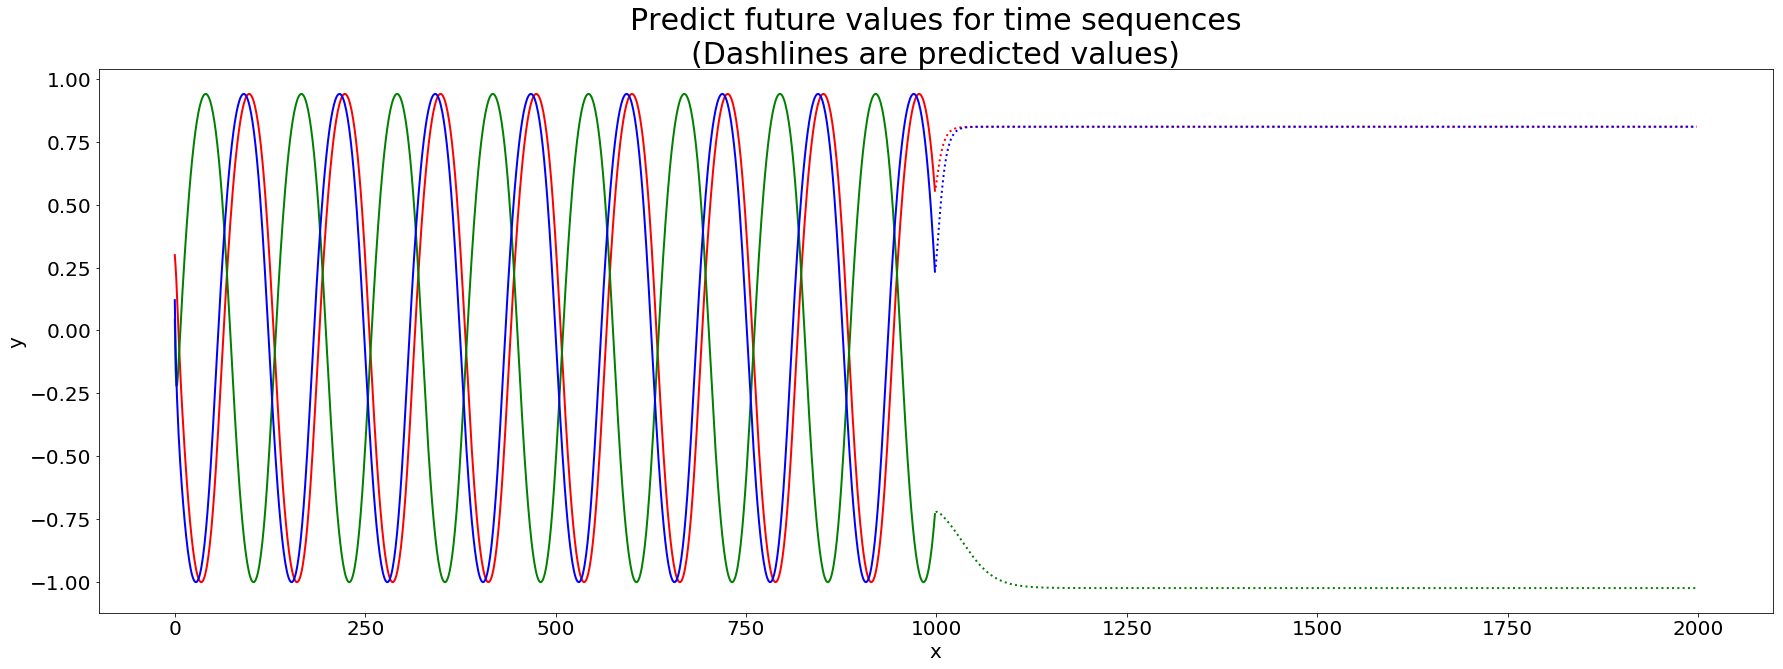

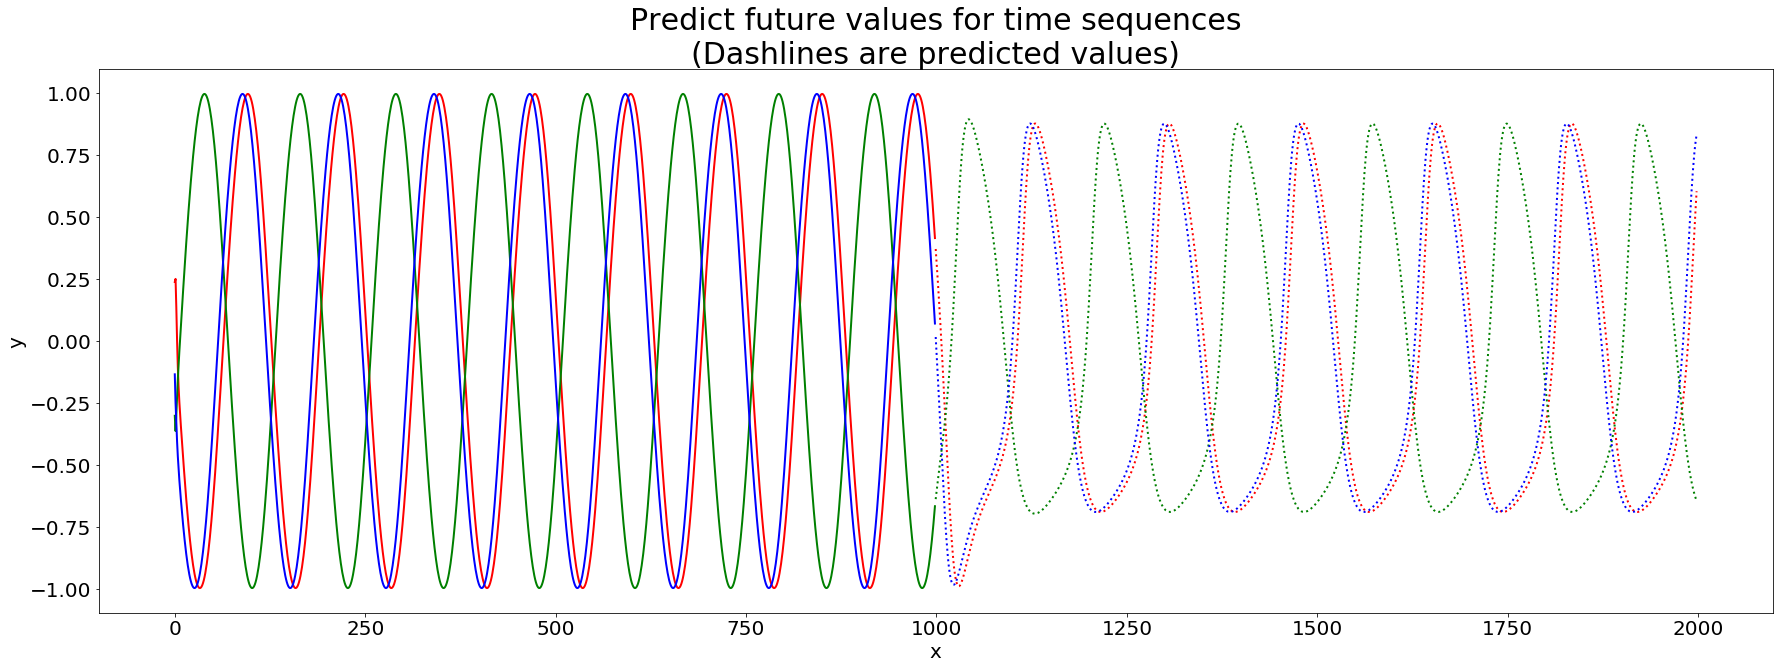

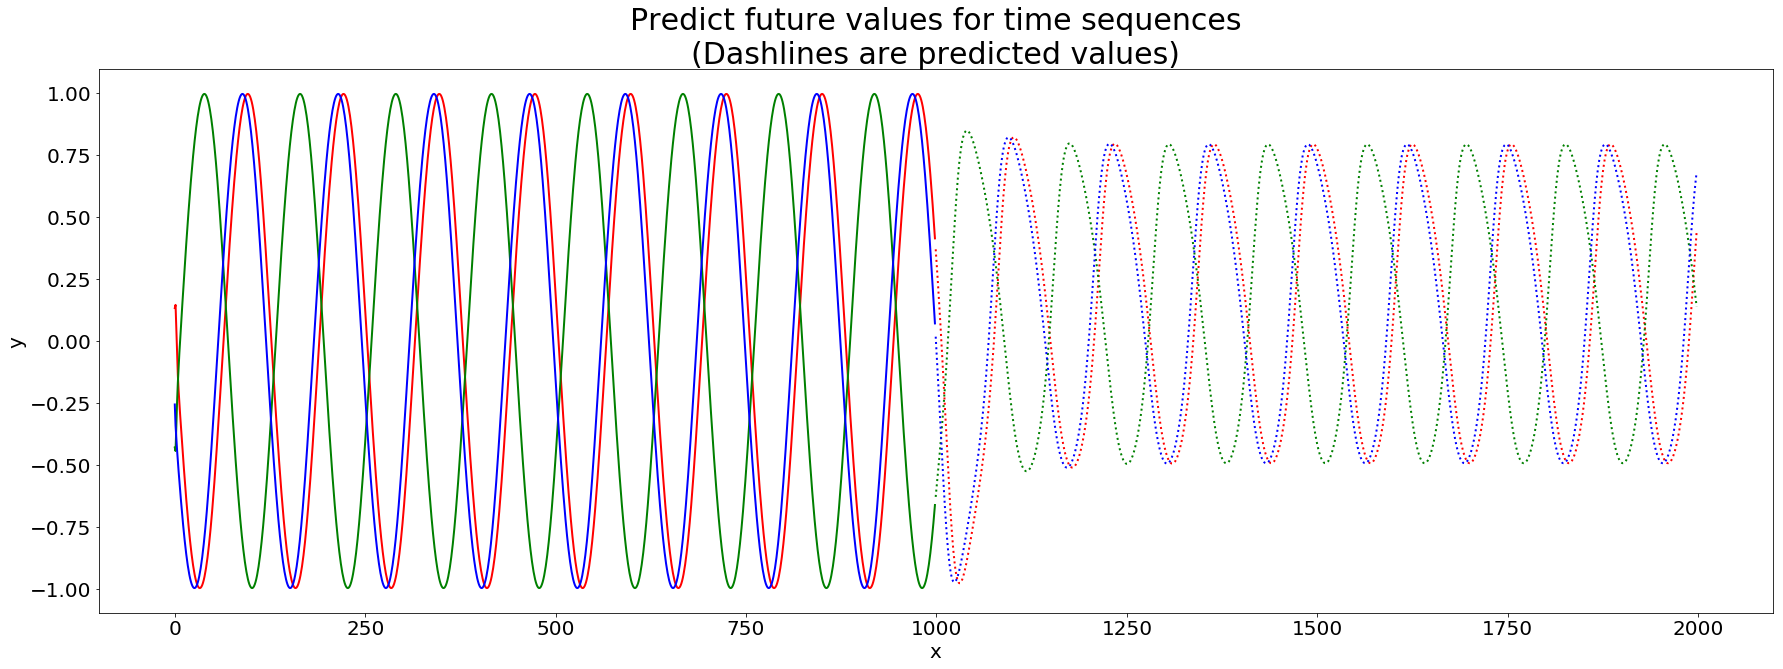

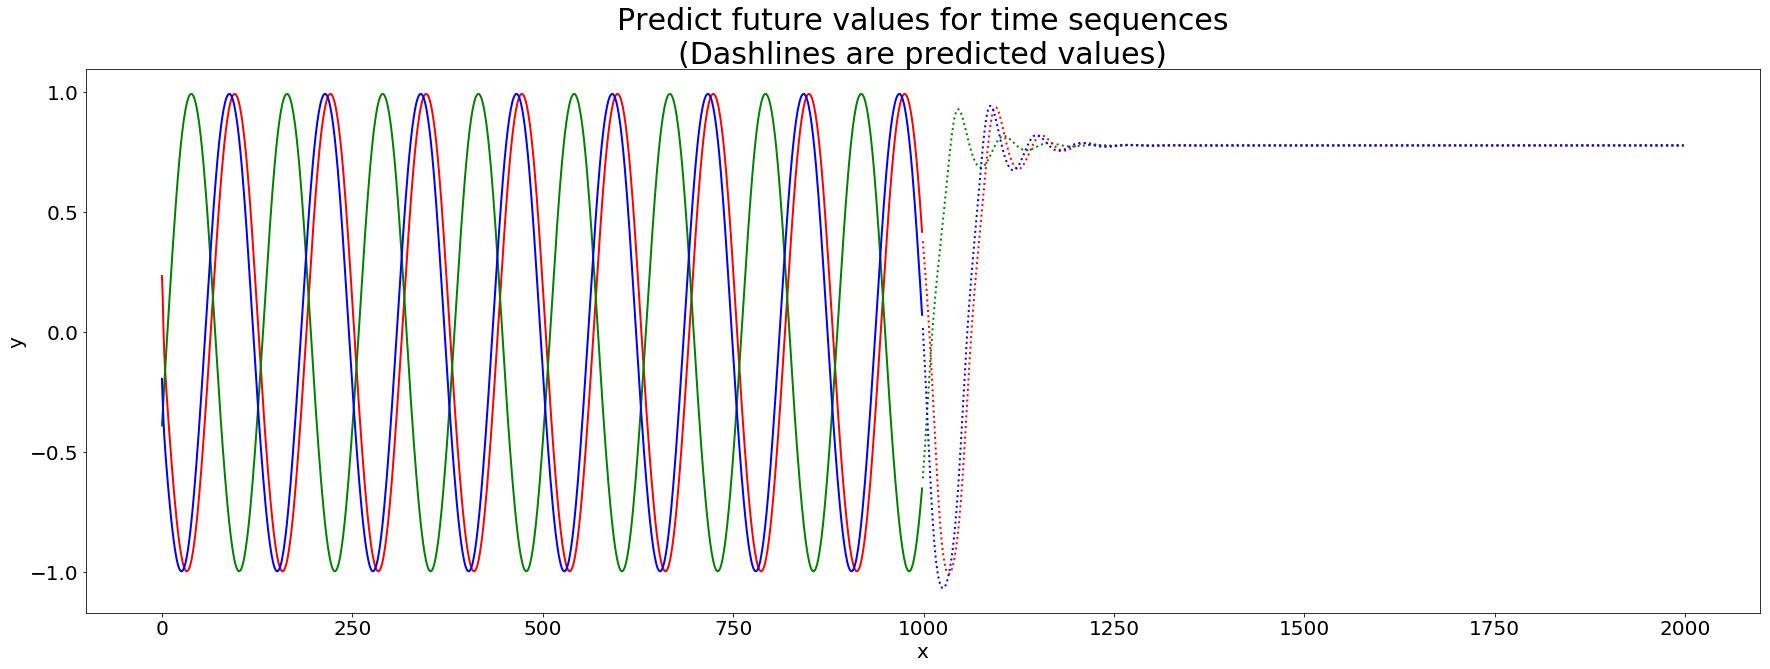

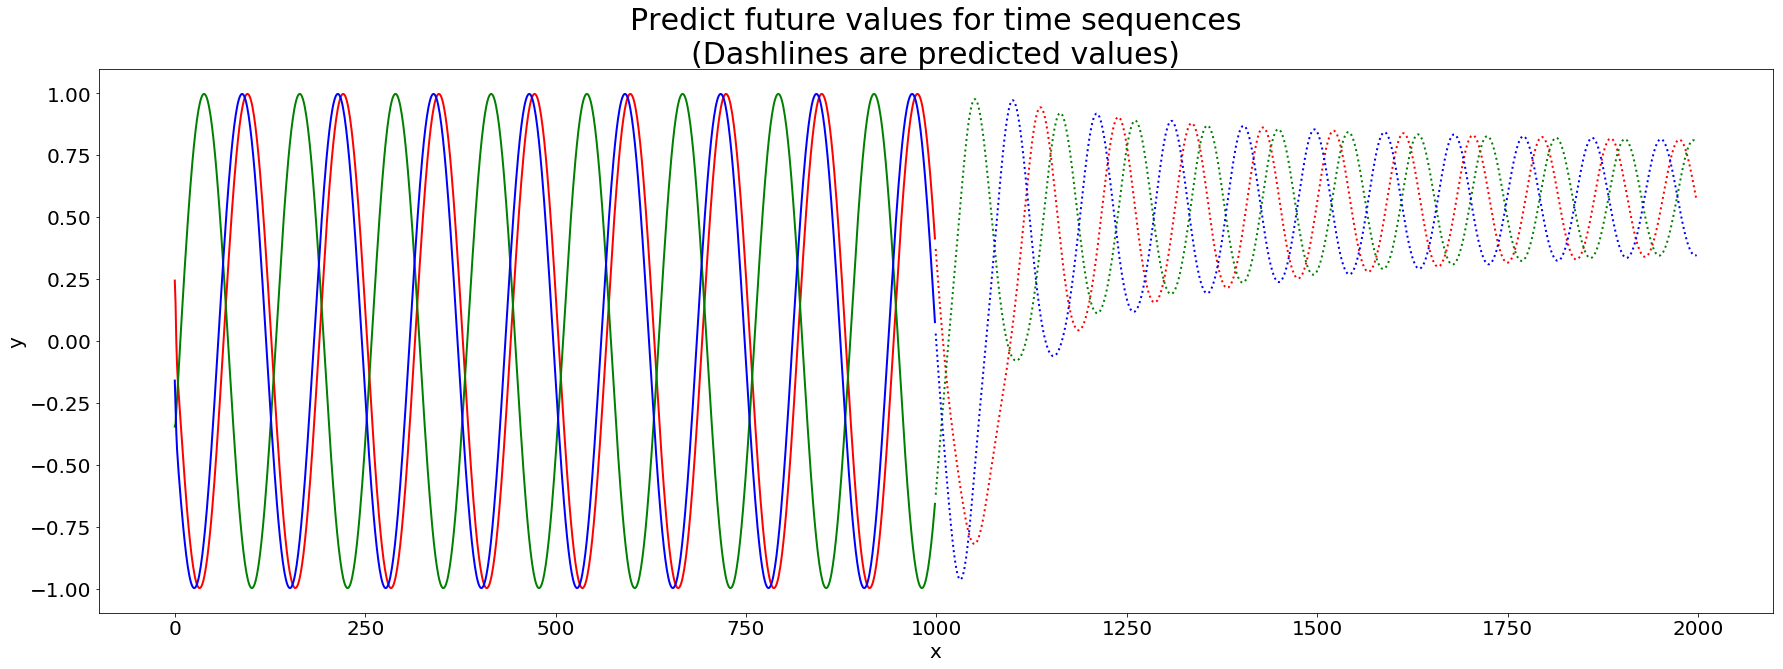

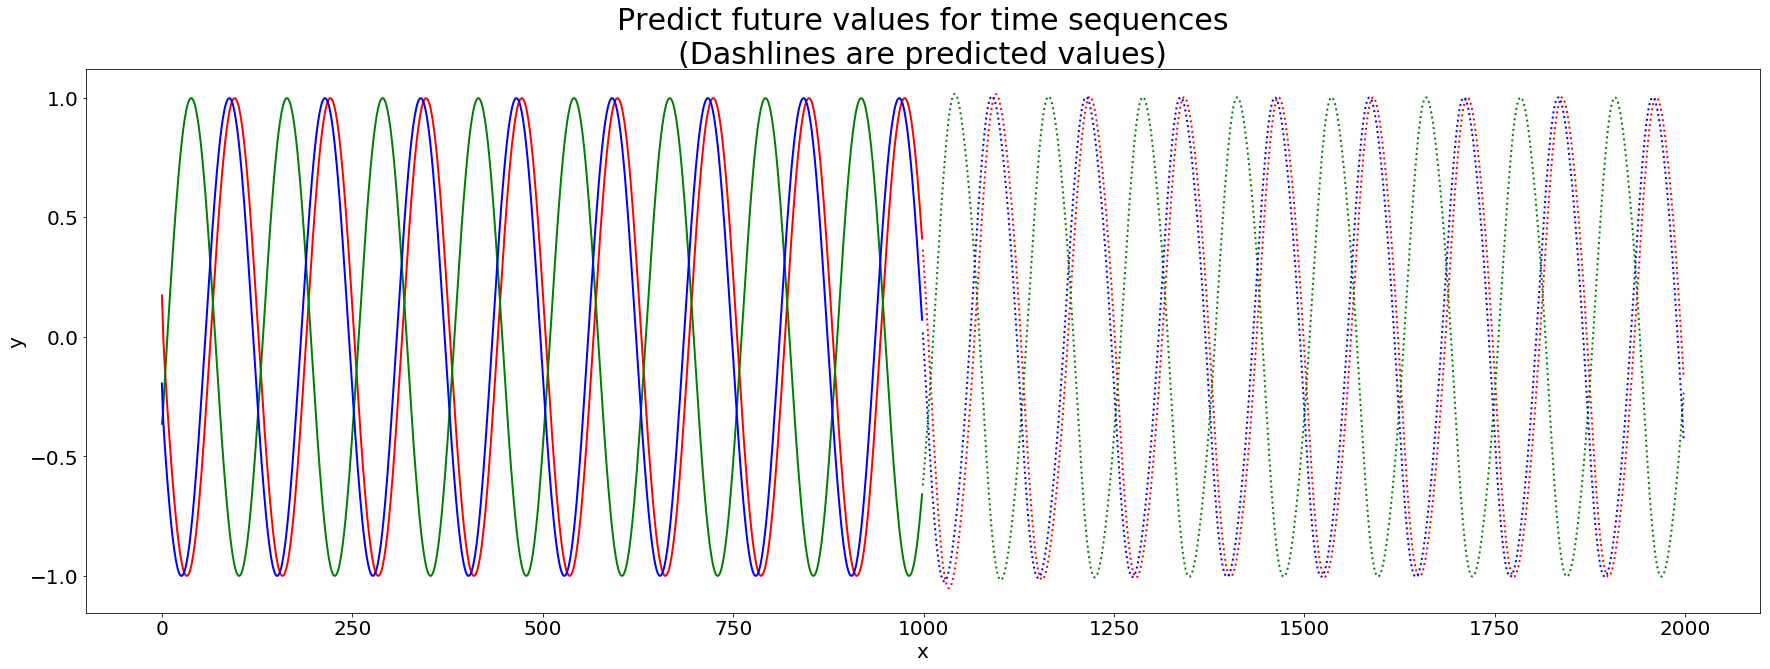

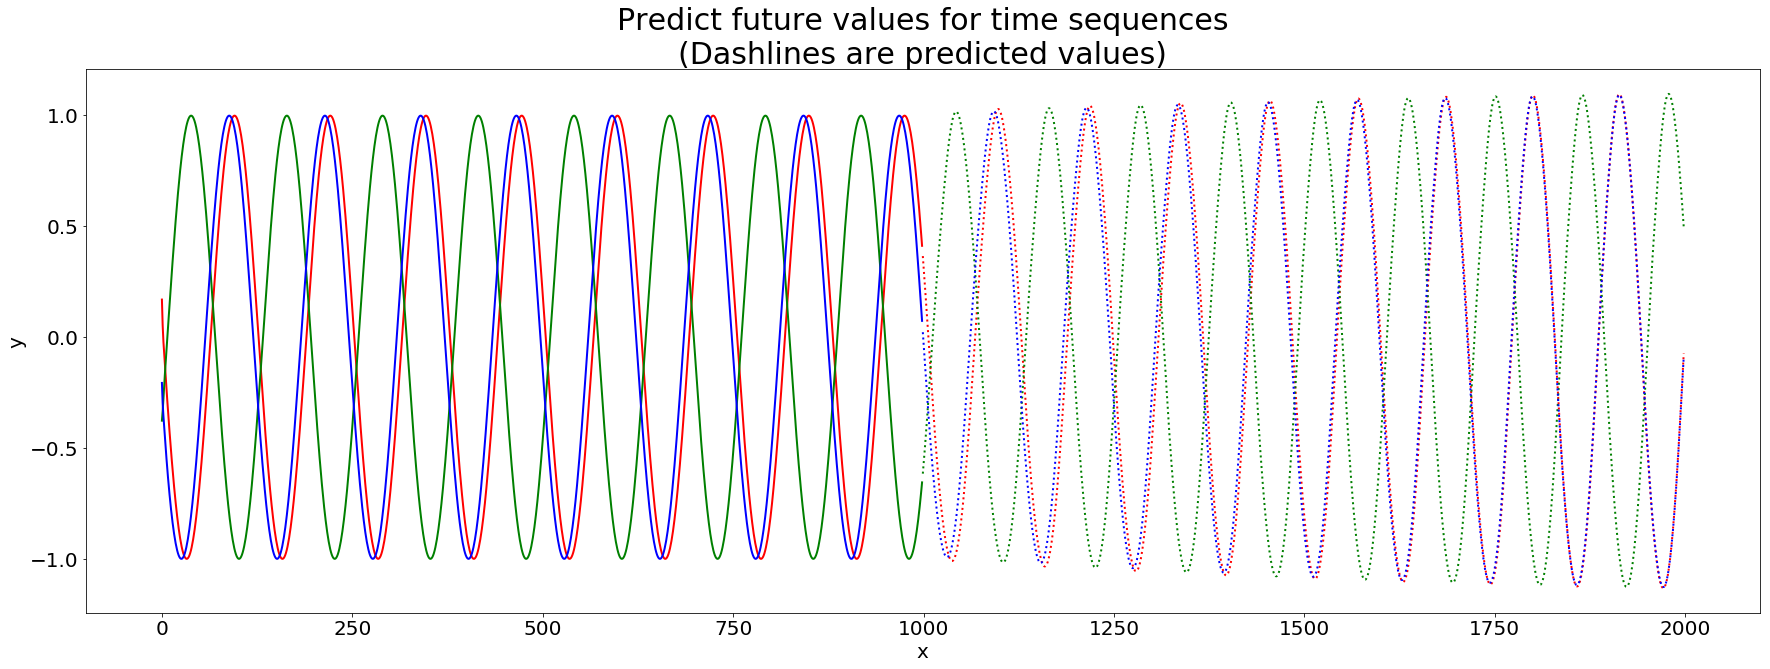

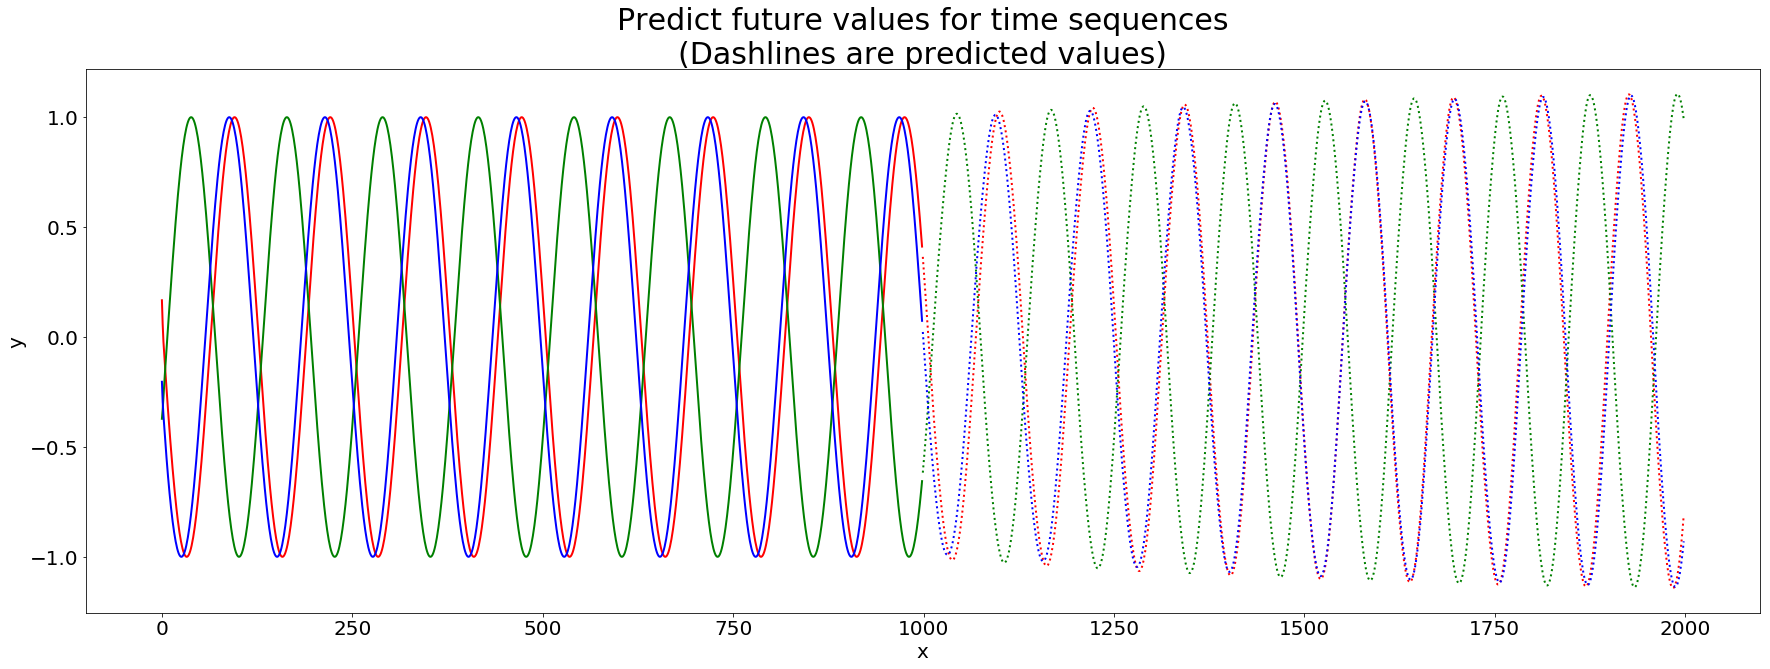

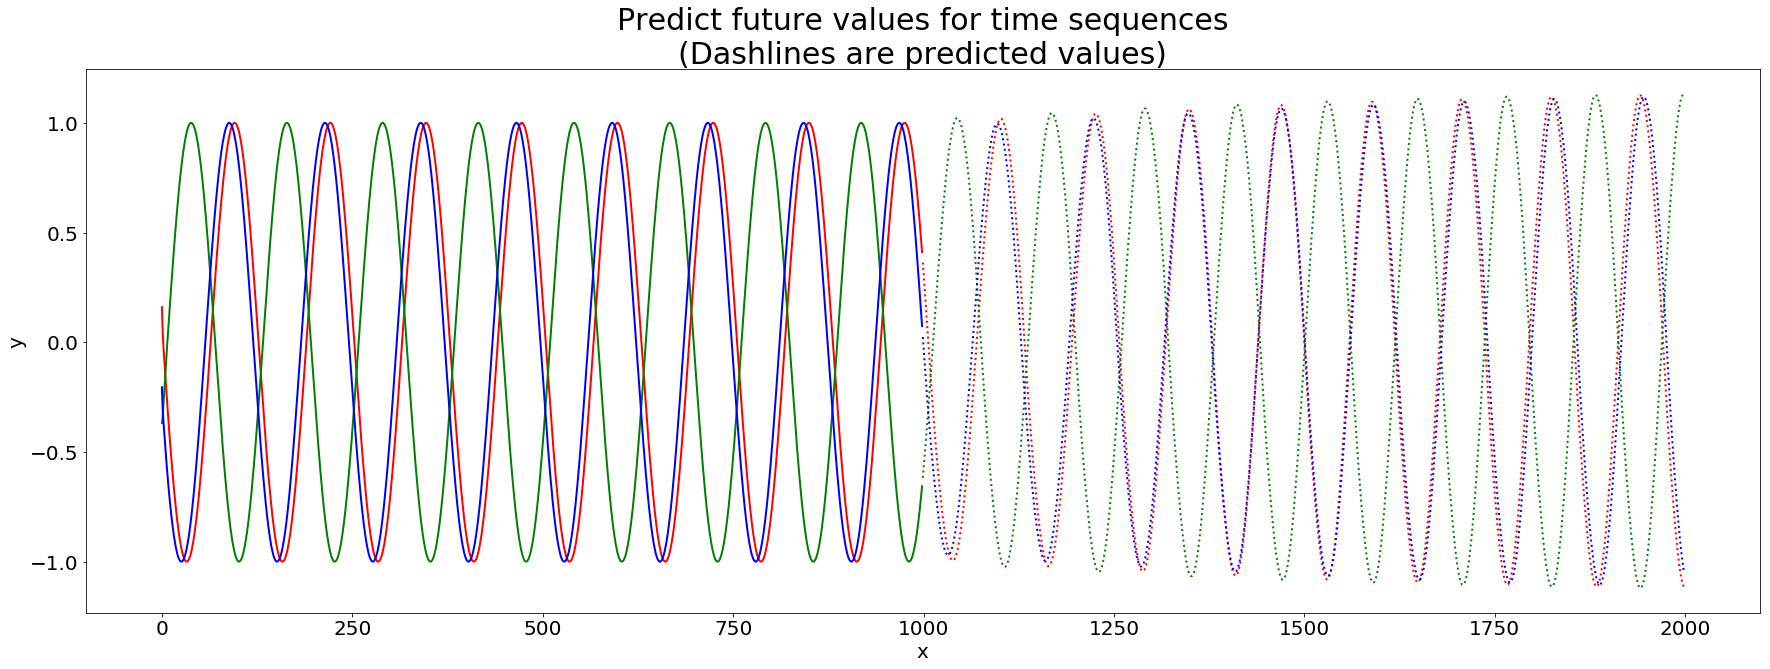

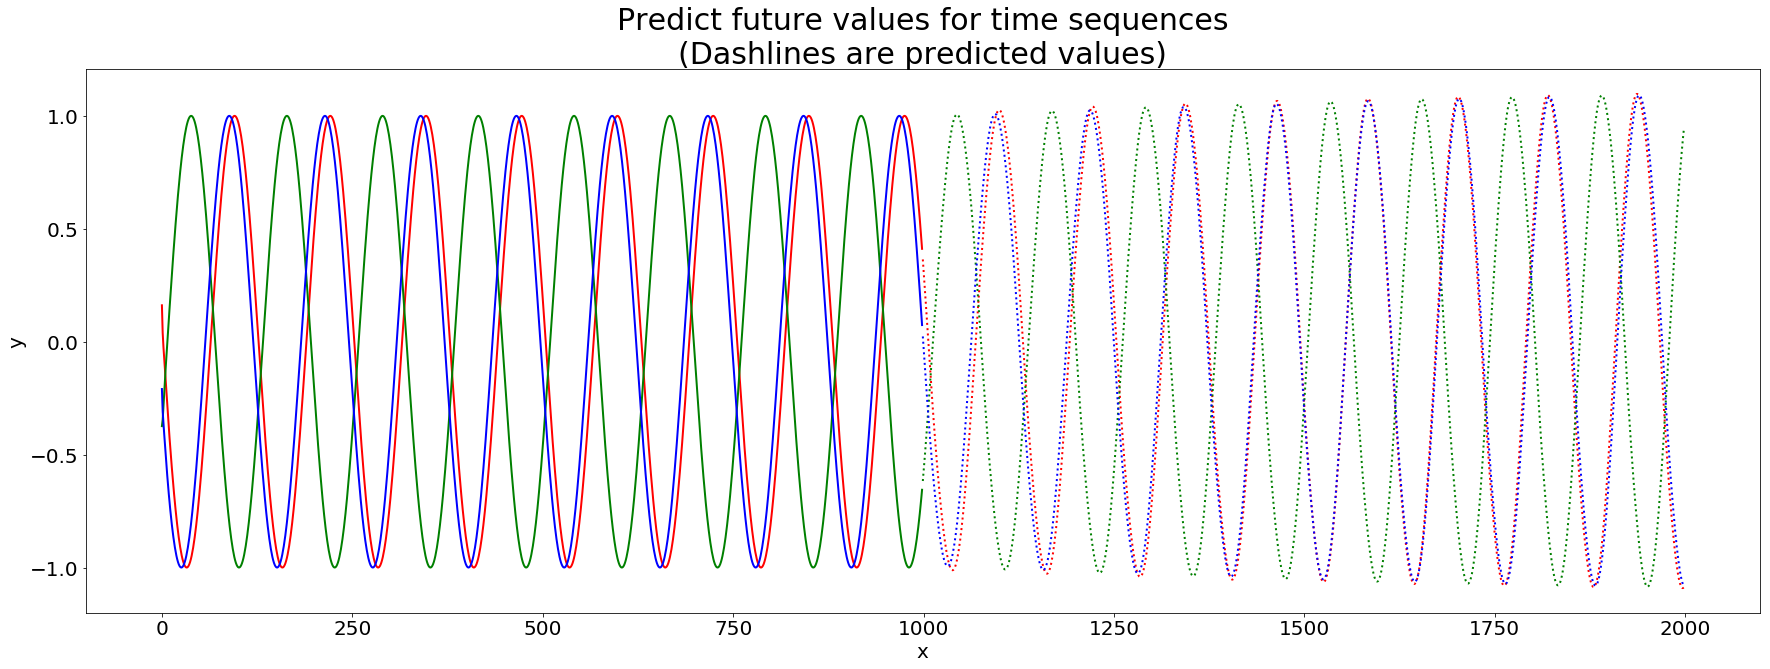

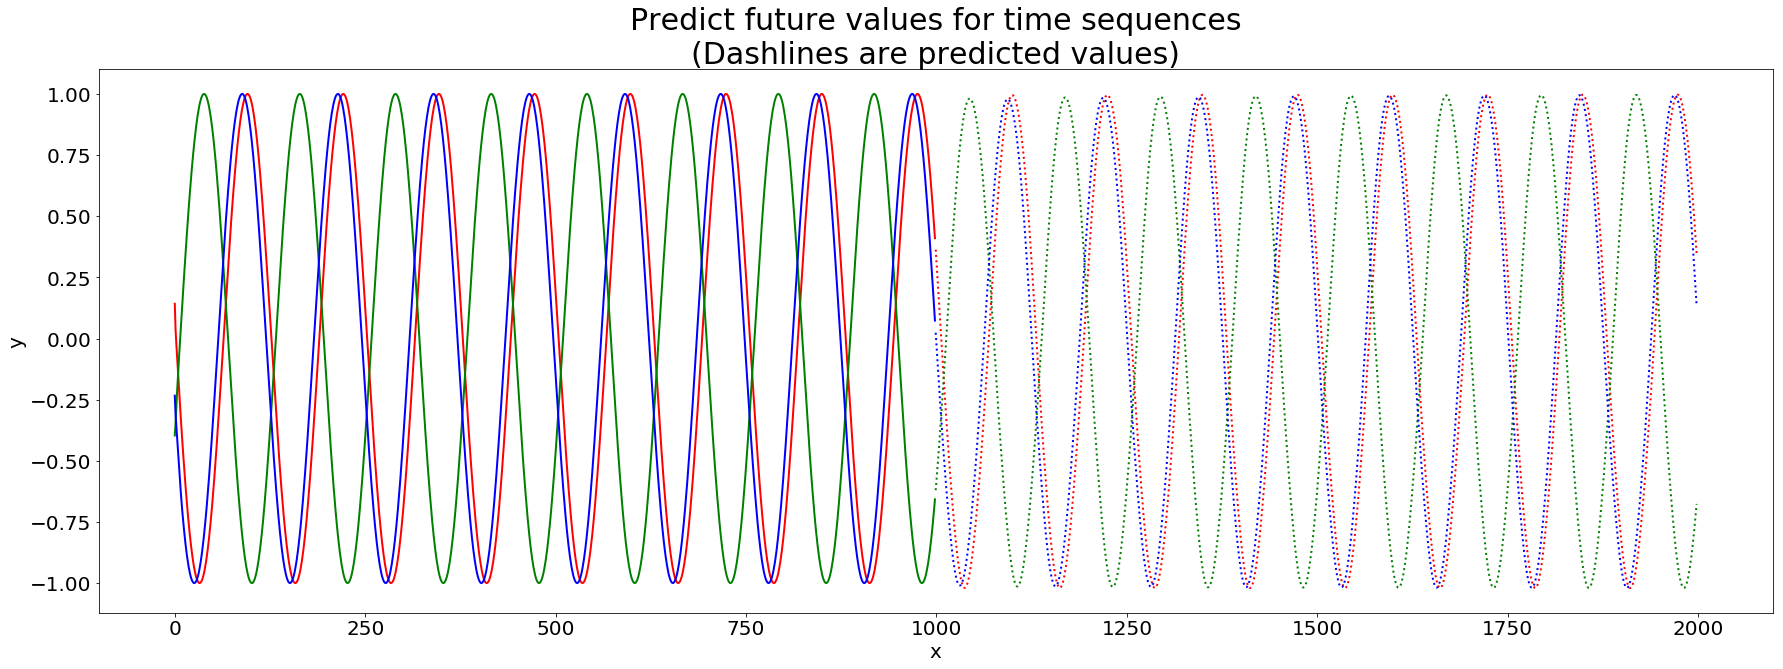

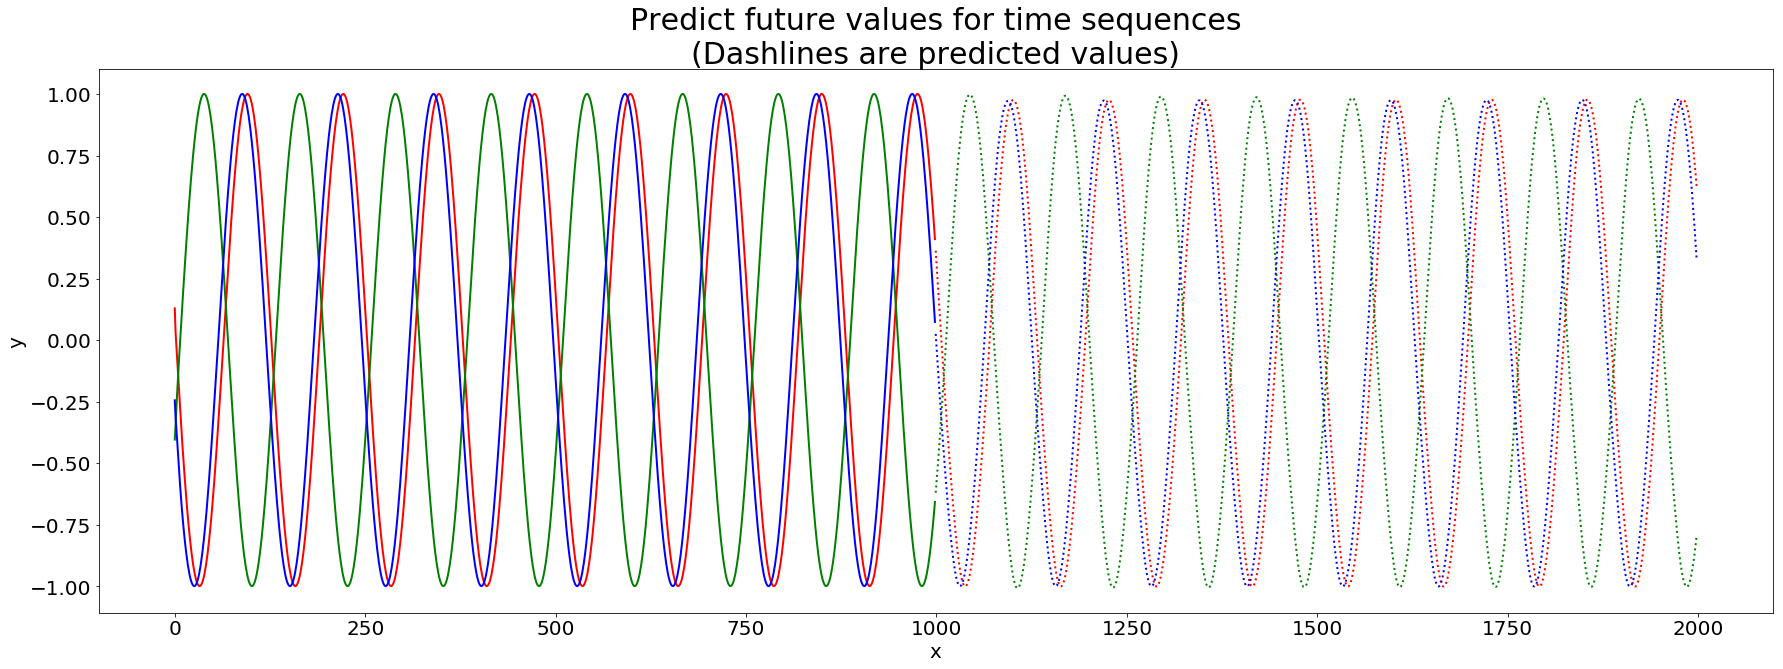

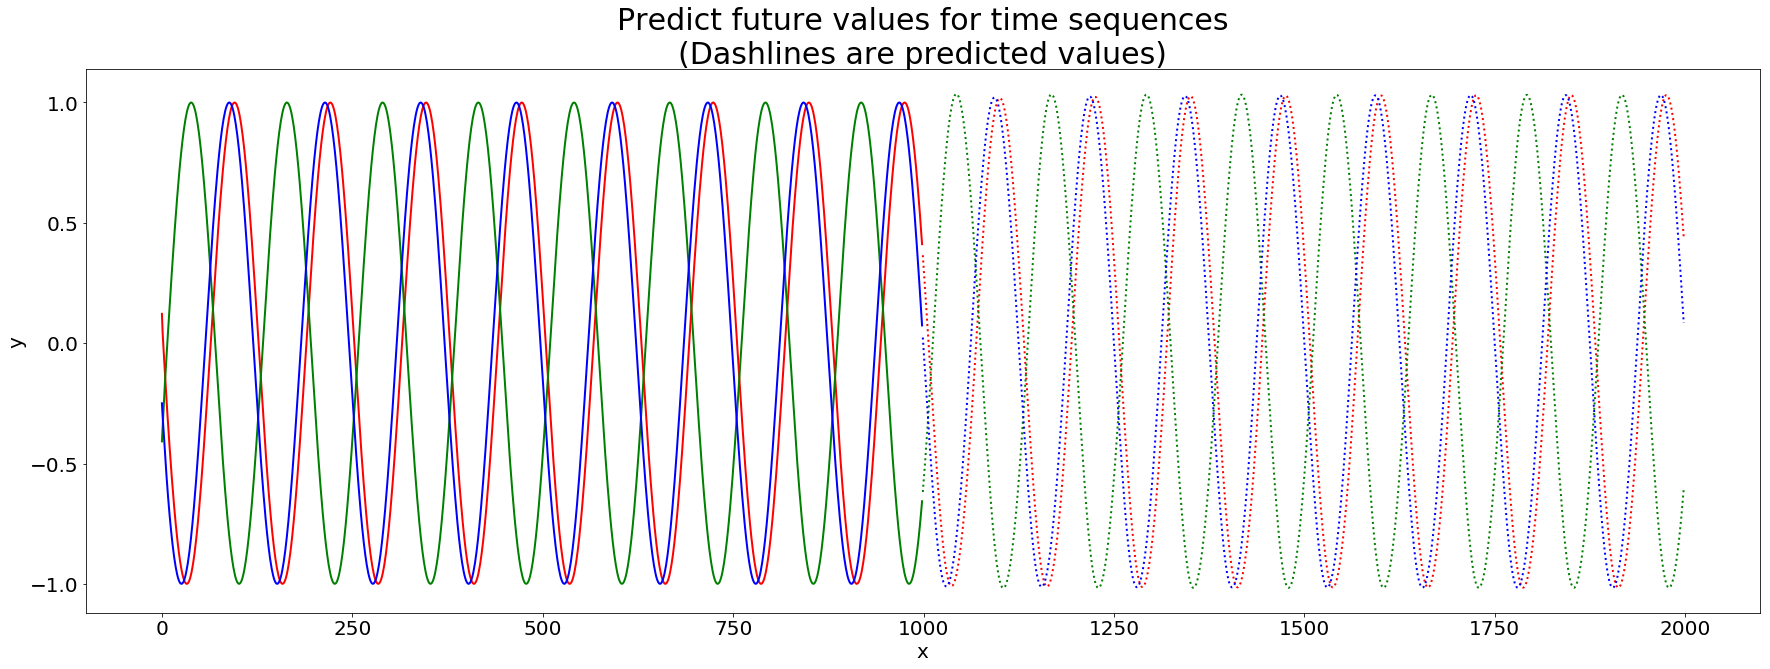

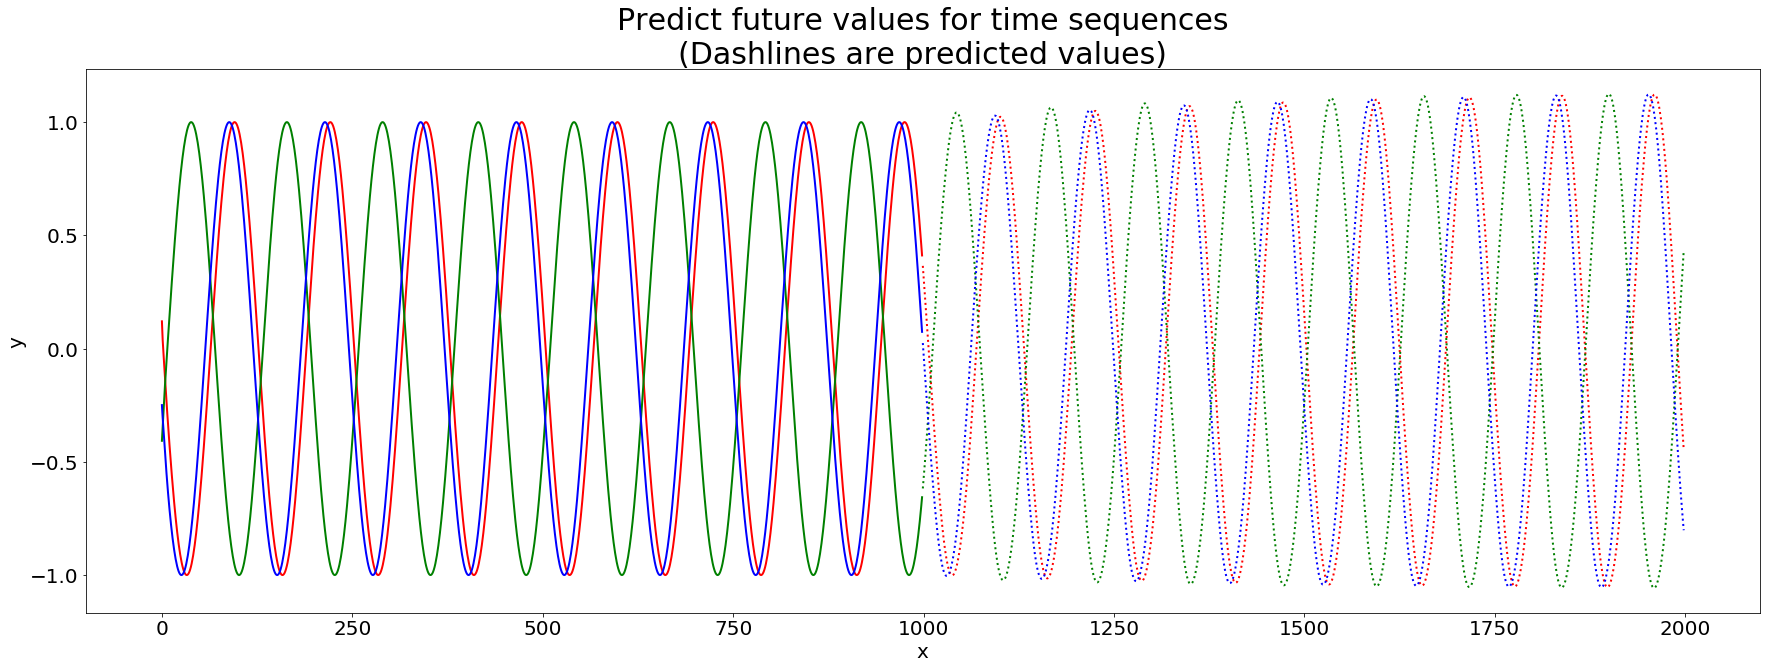

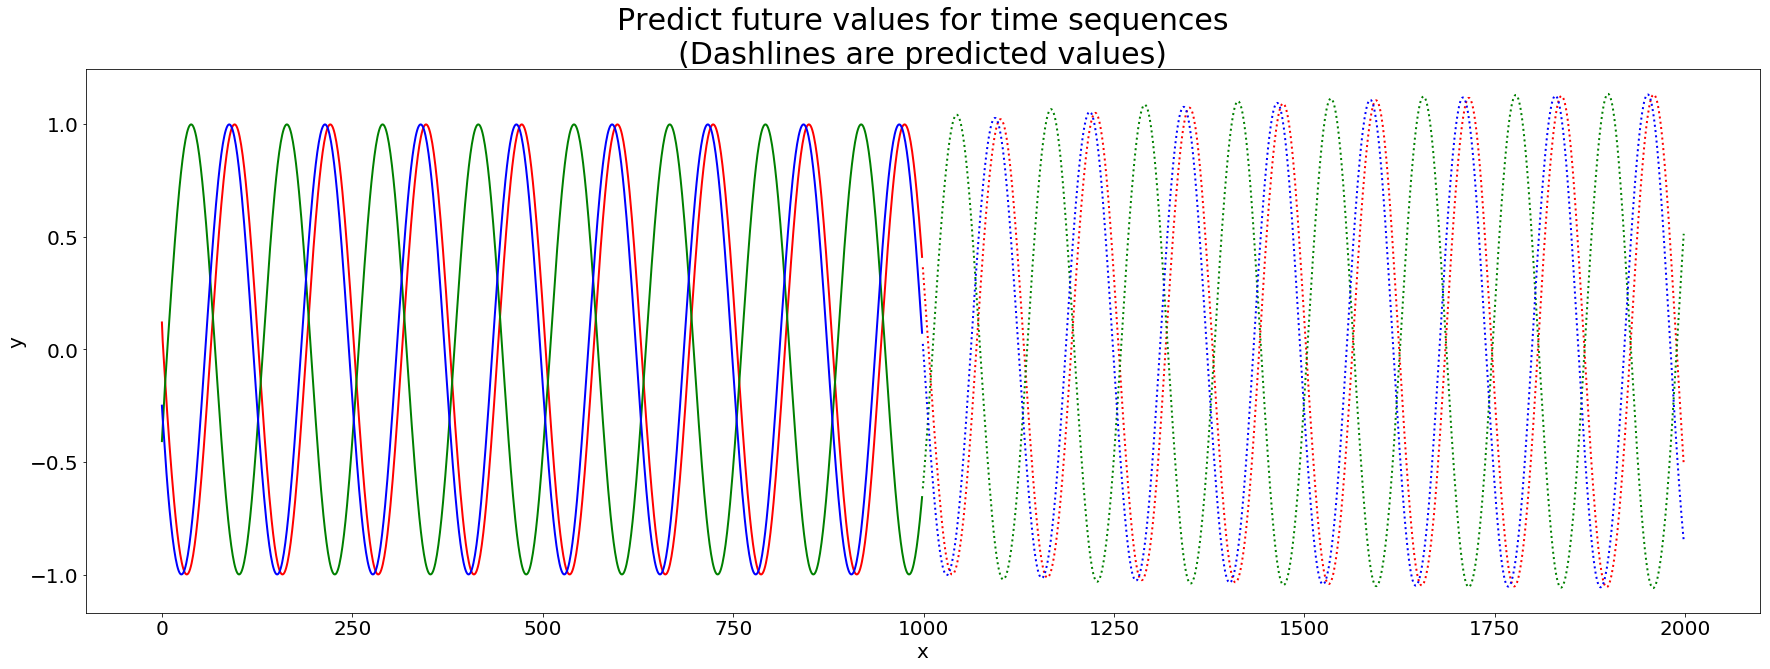

In [96]:
#begin to train
tic = time.time()
history = []#<-- We could store loss values here for later 

for i in range(epochs):
    print('STEP: ', i)
    
    
    """
    *** THIS CODE RUNS TWENTY TIMES PER EPOCH *** 
    
    This section runs 20 minibatches over the data, allowing for the accumulation of 
    backpropogated gradients through each minibatch. At the start of the minibatch, 
    the gradients are reset to zero and the training process continues. 
    """
    
    def closure():
        #print("Closure")
        # Use zero_grad() with the LBFGS Optimizer so we accumulate gradients on backpropogation
        optimizer.zero_grad() 
        
        # use the 'seq' object and provide it with the training set 'input' which it will use to learn 
        # the sine function through time from the data in 'input'
        out = seq(input)
        
        # remember our loss function is simply MSELoss, so our loss function is taking the 'out' predicted
        # in the previous line and finding the sum of the squared error in the y-direction between the 
        # actual sine waves and the predicted next step in the wave
        loss = criterion(out, target)
        
        # we can now print the loss, or the mean squared error between the predicted points and the true points
        print('loss:', loss.item())
        
        
        loss.backward()
        
        return loss
   
    optimizer.step(closure)
    
    # begin to predict, no need to track gradient here
    
    """
    *** THIS CODE RUNS ONLY ONCE PER EPOCH *** 
    
    This section sets future to 1000, changing the role of the seq object from training 
    to predicting the next 1000 elemnts of the approximated function f*(x) 
    """
    with torch.no_grad():
        print("TEST")
        future = 1000#<-- Set future=1000 which will allow the sequence object to predict into the future
        """
        Remember that when we created our Sequence class we built a function called 'forward' in which 
        we initialized 'future' to zero. Here, however, we set future=1000 which lets our sequence object 
        know that we want to predict values into the future! (1000 values into the future)
        
        And now future=1000 now gets passed into the sequence object along with the test data "test_input"
        which is simply the first three of our randomly phase shifted sine waves we generated at the beginning
        
        The design of the Sequence class is very clean so subsequently our instantiation of Sequence as 'seq' 
        is easy to use, we simply train it above and use it to predict new data. 
        """
        
        # The seq object has now been trained for i epochs and we are ready to test the current state 
        # of the network by passing a future value of 1000 to the object and recording its predictions
        # We give it 'test_input' which is simply three of our sine waves and future=1000 which allows 
        # our Sequence object to generate 1000 predictions into the future. 
        pred = seq(test_input, future=future)#<-- future = 1000 
        
        # We can now find the MSELoss between our N=3 sine waves and the true data which we are trying to predict
        loss = criterion(pred[:, :-future], test_target)
        
        # Using loss.item() simply returns the scalar value of the item stored in the loss function
        print('test loss:', loss.item())
        
        # Lastly, we want to plot our predictions so we use the .detatch().numpy() function to take our 
        # torch dataframe and convert it into numpy vectors which can be plotted using matplotlib 
        y = pred.detach().numpy()

        """
        Finally we can draw the result to show that our network is either approximating the function well, 
        or show that we still have error in our test predictions
        """
        
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    

toc = time.time()

In [97]:
#We can use the 'time' package to measure how long it takes to train the model
train_time = toc - tic
secs = train_time%60
mins = (train_time - secs)/60

print('Time taken to train on', epochs, 'epochs was:', mins, 'minutes and', secs, 'seconds.')

Time taken to train on 15 epochs was: 5.0 minutes and 39.49153470993042 seconds.


We can see that the final iteration produced a result with a test loss of 6*10^-6 and a qualitatively accurate visual continuation of our testing sine wave. 



# Final Remarks
------

This project was a good example of why LSTM units are needed and the advantages that RNNs have over traditional dense, fully connected networks. It also shows how to create a sequence class using LSTM units in pytorch which allows us to instantiate a sequence object which is able to learn from time series data and make accurate predictions into the future. One key takeaway from this project was connecting the conceptual idea that RNNs work by learning from both the input features and the previous state of the network, and we were able to code that directly using h_t and h_t2 in the Sequence class. It was also interesting to discover the correct way to generate output predictions for test (future) values is simply by feeding the previously predicted value back into the function to subsequently get propagated through the network. This way the network is either training and generating output in an attempt to approximate the training data, or testing and attempting to predict some f(t) for some t value in the future. 
